In [1]:
from IPython.display import Image

## Image processing for pheno-sudoku  
### Plan  

1. Ground truth:  
    a) Bin image to 4 chunks of 256x256;  
    b) Code for random selection of images from the screen (x20); perform LoG on channel 3, make RGB image, R/G/B = 80/10/10 (R = ch3, membrane); Code how to normalize channels for all the images;  
    c) create masks.  
2. Training of StarDist  
3. Segmentation 
    a) Import (use random selection)    
    b) Predict centroids and vertices  
    c) Estimate surface  
    d) Remove polygons under threshold  
    e) Export single cell img  
4. Clustering with unsupervised CNN  

When trained unsupervised net...  
1. visualize clusters
2. show normalized mutual information increase


**04/24/19 Update**  
All plates but 3:5,9,14 finished.  


### Deepcluster  
AlexNet arch was trained on nuclear crops from 1 field of view from every well of Pt04. For 100 epochs

## DL instance setup

```bash
conda create --name imgSudoku pandas numpy scipy seaborn opencv scikit-learn matplotlib tensorflow-gpu
conda activate imgSudoku

wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/cuda-repo-ubuntu1604_10.1.105-1_amd64.deb

sudo dpkg -i cuda-repo-ubuntu1604_10.1.105-1_amd64.deb
sudo apt-key adv --fetch-keys http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/7fa2af80.pub
sudo apt-get update
sudo apt-get install cuda


```



### Agenda for 05/09/19  
**Synopsis:** we performed an image based screen on CRISPR-Cas9 induced knock outs of druggable genes. To analyze the phenotypic complexity of each knockout, I extracted single cell (nucleus) images using deep learning based segmentation. Total scale of data resulted in over 76 million single-nucleus images. To analyze phenotypic changes I used unsupervised deep learning and clustered the data (using deepcluster to train AlexNet model) in 100 arbitrary clusters. AlexNet was trained using 1 million single nucleus images.  

**Questions for a downstream analysis of the full dataset (alternatives):**  
1. Should I re-configure deepcluster-trained AlexNet to perform classification tasks on N pseudo labels? How to approach? I can remove the top layer and use input from last conv layer (4096 features) and map them to N clusters. Do you have recommendations how to re-arrange AlexNet in this case?  
2. I can extract 4096 features from conv5 for every image and perform the clustering. How should I go about this number of observations - loading full dataset and doing PCA seems infeasible? There are ways for incremental PCA clustering, not sure if they work with downstream UMAP. Also there is an online learning... What are the prerequisites to use either?  
3. How would you recommend to organize the infrastructure of this data? SPARK, Hadoop, SQL?  
4. Which stastistics to use for cluster evaluation?
5. Any recommendation of demonstrating interpretability of clustering net? Feature importance map?



### Update 05/07/19  
All plates finished and backed up (finished 05/03).  
How to process (alternative approaches)

1. K-means  
2. PCA/UMAP (with louvain and leiden)  
3. Unsupervised SVM  
4. Spectral clustering  

Benchmark all of them based on Pt04_r07_c05 (Incenp sgRNA1	190219_195942-V	G5)  

### Update 05/16/19  
Add also HDBSCAN  



#### K-means.  
Pre-trained AlexNet (described previously) run for 72 epochs to assign clusters for:  
    
    – Pt04_r07c05
    – Pt04_r07c05
    – Pt11_r02c12
    
Further training improved clustering with Louvain method (see `deepclust_multiple_samples.ipynb`).  


### Update 05/20/19  

```
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r02/ --file Pt04_r02c12* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r05/ --file Pt04_r05c01* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r06/ --file Pt04_r06c02* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r07/ --file Pt04_r07c02* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r01/ --file Pt04_r01c01* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r07/ --file Pt04_r07c04* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r07/ --file Pt04_r07c06* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r08/ --file Pt04_r08c01* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r08/ --file Pt04_r08c03* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r08/ --file Pt04_r08c05* -o ~/data/train/
  python copy_big_data.py -i /sudoku/02_sudoku/cropped/Pt04/r08/ --file Pt04_r08c07* -o ~/data/train/
```

#### Continuing training with PIC
Launched another training of 102-epochs pre-trained alex net on the following:  
```
Haus8 sgRNA #1	190219_195942-V	B12	
Haus8 sgRNA #2	190219_195942-V	E1	
Haus8 sgRNA #3	190219_195942-V	F2	
Haus8 sgRNA #4	190219_195942-V	G2	
DyncH1 sgRNA #3	190219_195942-V	A1	
Incenp sgRNA #1	190219_195942-V	G4	
Incenp sgRNA #2	190219_195942-V	G6	
Incenp sgRNA #3	190219_195942-V	H1	
Rad21 sgRNA #1	190219_195942-V	H3	
Rad21 sgRNA #2	190219_195942-V	H5	
Rad21 sgRNA #3	190219_195942-V	H7	
```
**NOTE** Testing PIC clustering for this one, since clusters are not balanced.

**Conclusion** After 15 epochs of re-training shows a fair cluster separation on evaluation data. Level of abstarction seems lower than k-means training. Results in https://github.com/Gvaihir/image_sudoku/blob/master/deepclust_test_PIC15ep.ipynb  
Started to train AlexNet with PIC further  


#### Continuing training with Kmeans (total 300 epochs)  
Launched another training of 102-epochs pre-trained alex net on the following:  
```
Haus8 sgRNA #1	190219_195942-V	B12	
Haus8 sgRNA #2	190219_195942-V	E1	
Haus8 sgRNA #3	190219_195942-V	F2	
Haus8 sgRNA #4	190219_195942-V	G2	
DyncH1 sgRNA #3	190219_195942-V	A1	
Incenp sgRNA #1	190219_195942-V	G4	
Incenp sgRNA #2	190219_195942-V	G6	
Incenp sgRNA #3	190219_195942-V	H1	
Rad21 sgRNA #1	190219_195942-V	H3	
Rad21 sgRNA #2	190219_195942-V	H5	
Rad21 sgRNA #3	190219_195942-V	H7	
```

### Additional strategy  
Extract features from multiple convolutional layers and cluster them

### Clustering algorithms
1. **K-Means.** biggest difference pos control to negative controls (7.347984) is with 200 clusters. Too many clusters.  
2. **Affinity propagation.** Too slow, not scalable  
3. **Mean-shift.**. Too slow, not scalable  
4. **Spectral clustering.** Needs square matrix.
5. **Ward hierarchical clustering.** biggest difference pos control to negative controls (6.444544) is with 300 clusters. Too many clusters.  
6. **Manhattan Agglomerative clustering.** biggest difference pos control to negative controls (5.07809) is with 100 clusters. Too many clusters.  
7. **DBSCAN.** biggest difference pos control to negative controls (5.716354) is with eps 0.1. Still not enough. Also unstable, sometimes don't cluster at all.  
8. **OPTICS.** Too slow
9. **Gaussian mixtures.** Too slow, not scalable  
10. **Birch.** biggest difference pos control to negative controls (6.625232) is with 0.3 threshold. > 200 clusters with those settings.  
11. **Louvain.** biggest difference pos control to negative controls (3.270396) is with 2.5 resolution. Difference too small. Also "target cluster" (cytokinesis defects) is split between 2 UMAP clouds    
12. **Leiden.** biggest difference pos control to negative controls (3.421029) is with 2.0 resolution. Difference too small. Also "target cluster" (cytokinesis defects) is split between 2 UMAP clouds

#### **Conclusions**  
1. Test all same approaches with UMAP with higher number of dimensions. Use 10 UMAP dimensions  
2. Increasing of UMAP dimension to 10 or 20 didn't give any advantage with K-menas. Didn't test with the other algorithms
3. Tested K-means clustering on the non-treated with drug positive control and wyld type - no cytokinesis cluster enriched in the positive control wells.

### Metrics of clustering  
Choose metrics where class labels are unknown. 

1. Silhouette Coefficient  
2. Calinski-Harabasz Index  
3. Davies-Bouldin Index  

## References  
https://journals.aps.org/pre/pdf/10.1103/PhysRevE.80.056117 and https://www.nature.com/articles/srep30750 show Louvain to be most scalable  
https://arxiv.org/pdf/1708.02898.pdf set of benchmarks. Also idea of multiple layers for feature extraction  

other hierarchical clustering: http://delivery.acm.org/10.1145/3140000/3132960/p567-kozawa.pdf?ip=128.218.43.46&id=3132960&acc=ACTIVE%20SERVICE&key=CA367851C7E3CE77%2EAA74D1D15C30467C%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1559947183_9118772e86c74af70630190e976606b2  


https://github.com/rapidsai/cugraph  
https://medium.com/the-artificial-impostor/umap-on-rapids-15x-speedup-f4eabfbdd978


Trained clssifier on top of image net trained AlexNet

### Full cell segmentation  
Extraction of rgb images for plate 4:    
`python /home/anton/02_PhenoSudoku/oak180117_sudoku0002_DeepLearning/image_sudoku/image_merge.py --wd 190219_195942-V__2019-02-19T20_01_37-Measurement_1/Images/ --b_coeff 0.6 --g_coeff 0.7 --r_coeff 1.3 --tile_size 2048 --ntiles 1`

Training with the same samples:  

```
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r02/ --file Pt04_r02c12* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r05/ --file Pt04_r05c01* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r06/ --file Pt04_r06c02* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r07/ --file Pt04_r07c02* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r01/ --file Pt04_r01c01* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r07/ --file Pt04_r07c04* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r07/ --file Pt04_r07c06* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r08/ --file Pt04_r08c01* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r08/ --file Pt04_r08c03* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r08/ --file Pt04_r08c05* -o ~/data_rgb/train/
python copy_big_data.py -i /sudoku/crop_rgb/Pt04/r08/ --file Pt04_r08c07* -o ~/data_rgb/train/
```


Total: 582153 images  
Training settings from 0 epochs:  
```bash
DIR="/home/aogorodnikov/data_rgb"
ARCH="alexnet"
LR=0.05
WD=-5
K=100
WORKERS=4
EPOCHS=100
BATCH=256
EXP="/home/aogorodnikov/model_alex100_rgb_onImagenet"
PYTHON="/home/aogorodnikov/anaconda3/envs/imgSudoku/bin/python"
RESUME="/home/aogorodnikov/deepcluster_models/alexnet/checkpoint.pth.tar"
CLUST="Kmeans"
```
NMI check for *NMI for RGB images deepcluster from 0 epochs*  
Clusters to select ground truth from for classification:  
3, 7, 15, 17, 18, 25, 27, 28, 29, 31, 33, 46, 51, 52, 64, 80, 94

Training settings from 500 epochs ImageNet:  
```bash
DIR="/home/aogorodnikov/data_rgb"
ARCH="alexnet"
LR=0.05
WD=-5
K=100
WORKERS=4
EPOCHS=700
BATCH=256
EXP="/home/aogorodnikov/model_ImageNetPlus200_rgb"
RESUME="/home/aogorodnikov/deepcluster_models/alexnet/checkpoint.pth.tar"
PYTHON="/home/aogorodnikov/anaconda3/envs/imgSudoku/bin/python"
CLUST="Kmeans"
```
NMI check for *NMI for RGB images deepcluster from 500 epochs ImageNET*  
Clusters to select ground truth from for classification based only on 12 epochs:  
3, 6, 8, 12, 16, 17, 19!, 20, 21, 24,  25, 26, 31, 33, 35, 40, 51, 53, 60, 61, 62, 64, 68, 70, 71, 72, 75,76, 77, 80, 82, 83, 93, 94 

**Cluster selection done in `clust_visu.ipynb`**

**CONCLUSION**  
I will leave ImageNet-trained transfer learning, but will continue on Epoch0, because seems like ImageNet strategy gives too many clusters to choose from, meaning they are probably heterogenous.

### Training classifier  
Attempt 1: On alexnet trained on ImageNet for 500 epochs without transfer learning to k-means. **Accuracy:** 87%  
Attempt 2: On alexnet trained on cells for 100 epochs. **Accuracy:** 93%. - Use this one


Add WT Pt11_r02c12 - as purely negative class  

### Update 190813  
Hannah helped with refining cytokinesis class. Train classifier with those refined classes  

As per jimmie's suggestion - decreased size of training data to ~500 images. This resulted in accuracy drop from .88 to .78. See below.  
**Problem** some classes like "Y" or "Cytokinesis" have as little as 200-300 images 
Need data augmentation or collection of new data (annotation of more images) 

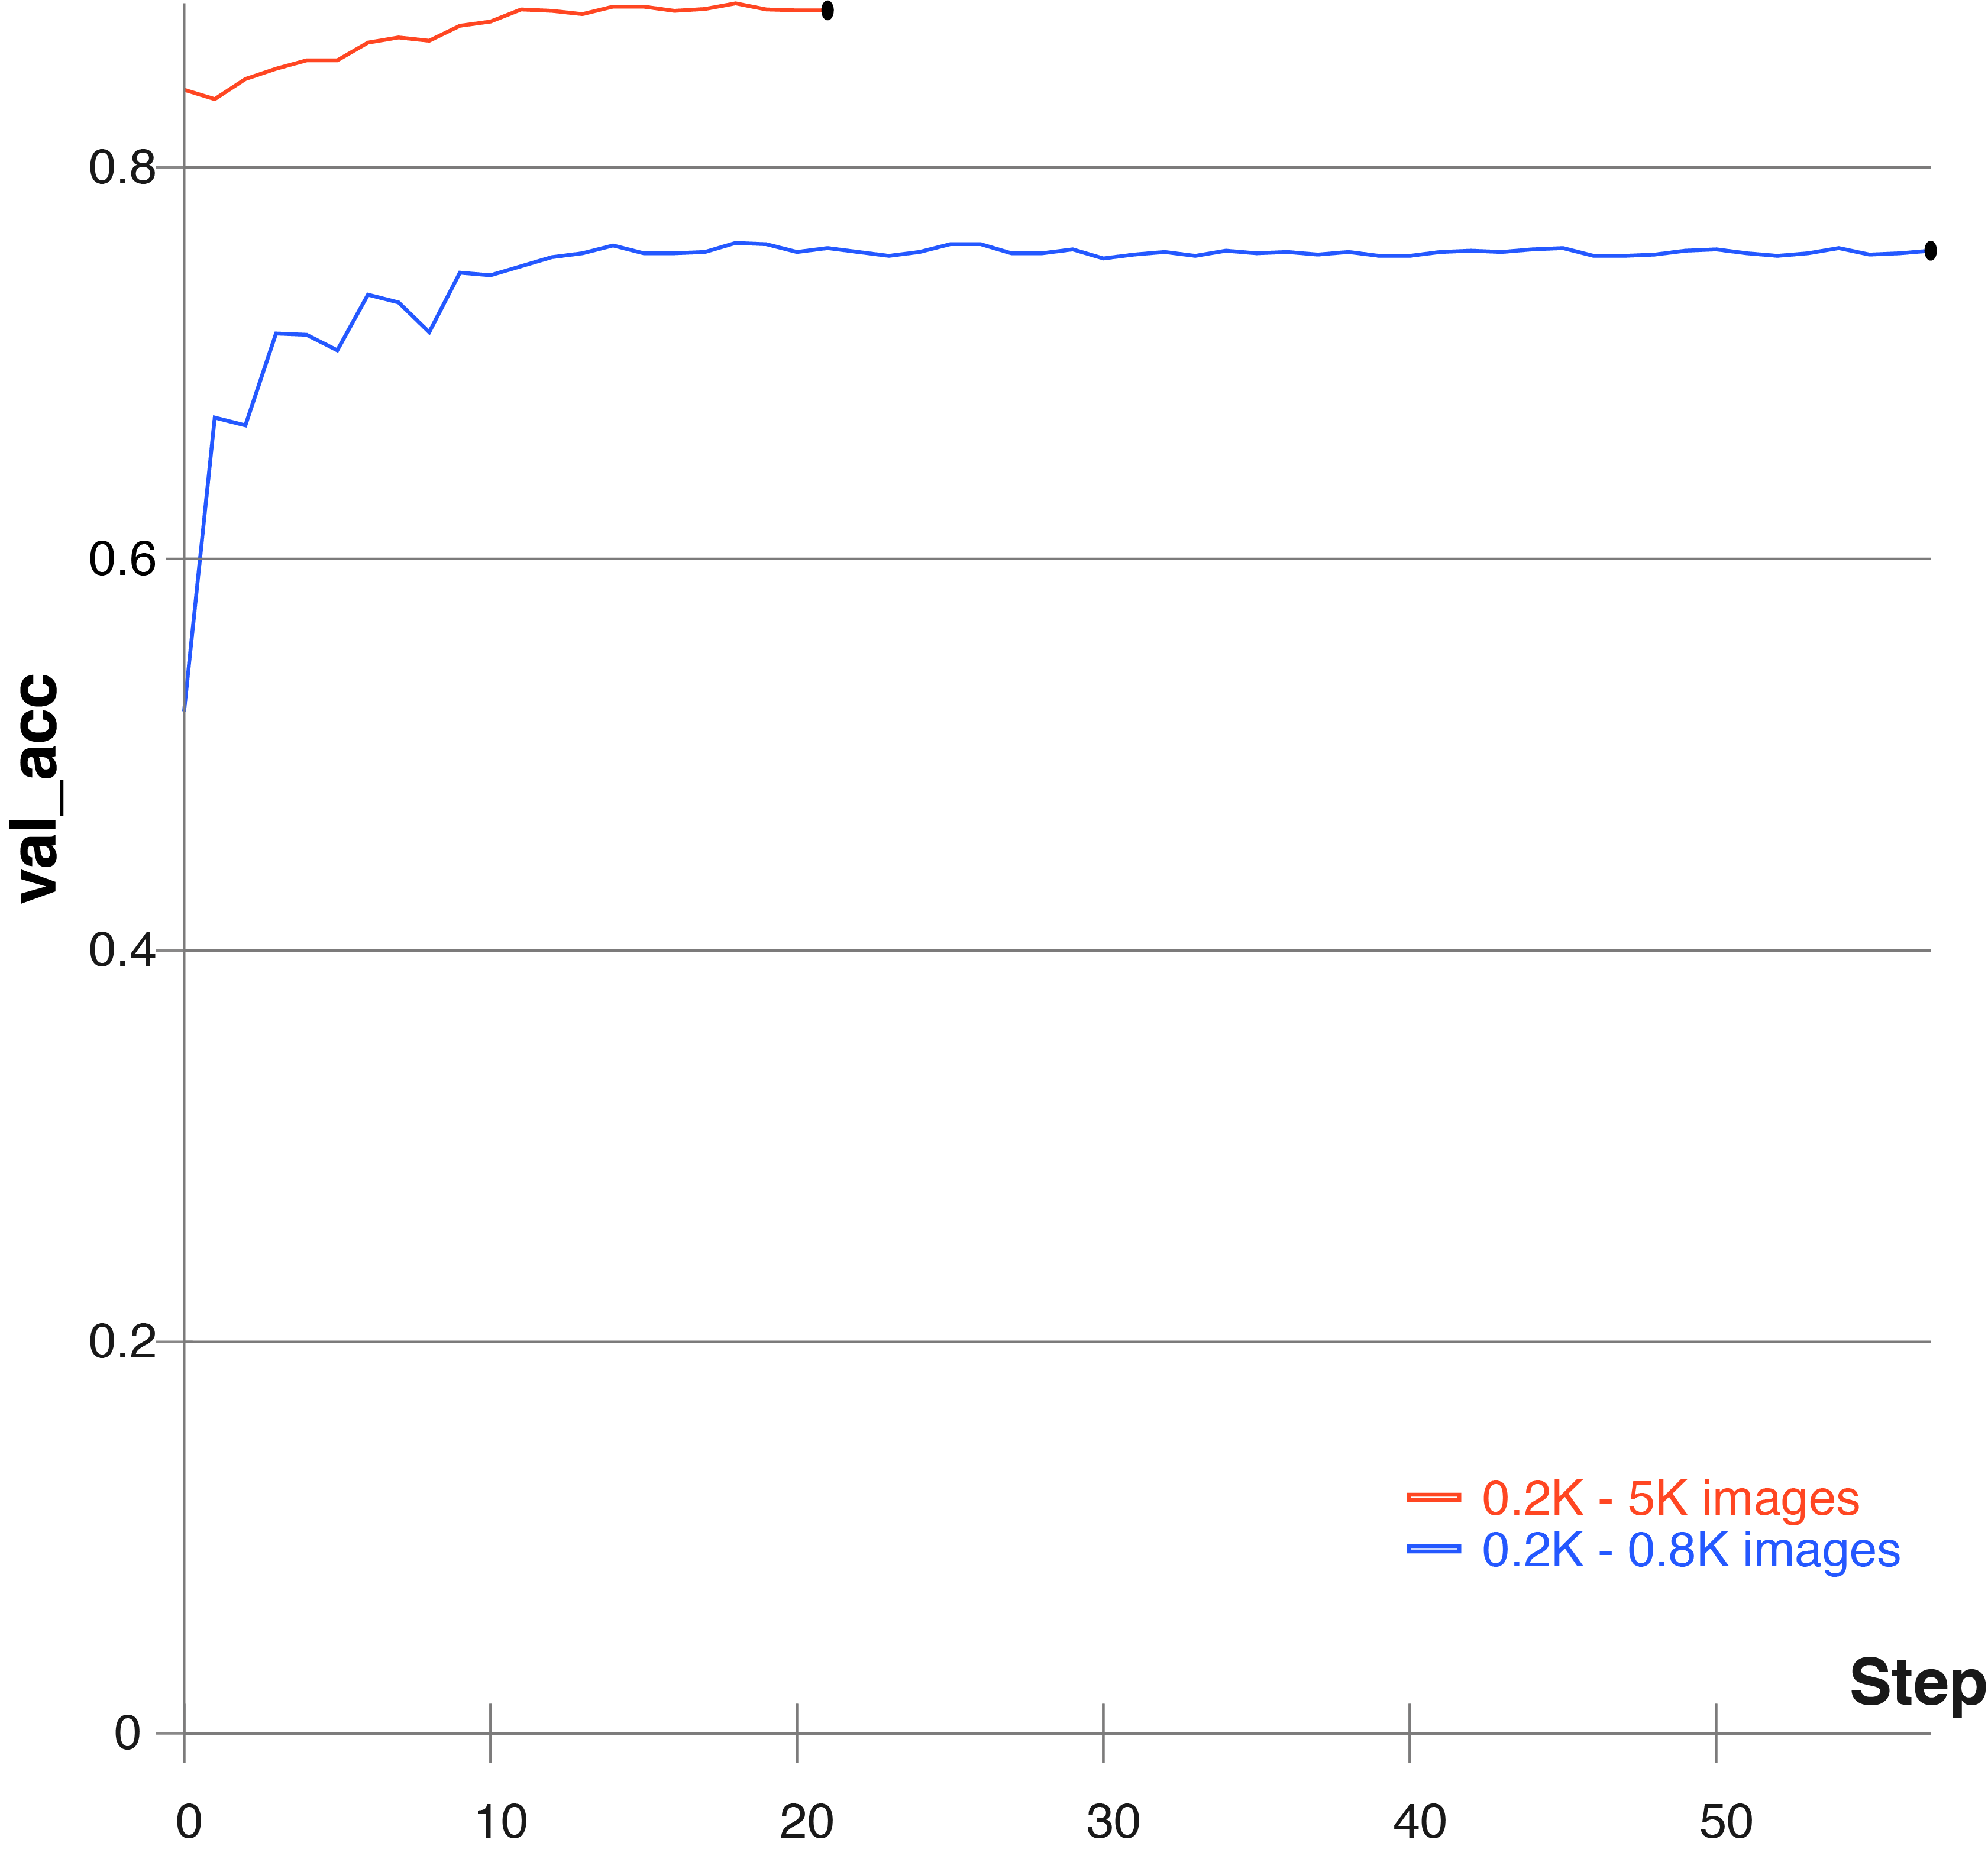

In [2]:
from IPython.display import Image
Image(filename='/Users/antonogorodnikov/Documents/Work/DataSci/01_sudoku_image/reports/wandb/large_vs_small_dataset.png',
      width=500, height=200)

### Update 190813  
Test augmentations on the data  
**Conclusion:**  
Still low accuracy on test set: 69%. Also apprently some classes specifically have low precision and recall (below) 
The probable inherited problem is that the dataset for clustering was inflated with cell without henotype, therefore the entire net is more likely to recognize those types of classes and make mistakes with other classes.  
Possible solution is to perform an anomaly detection and cluster/classify those types.

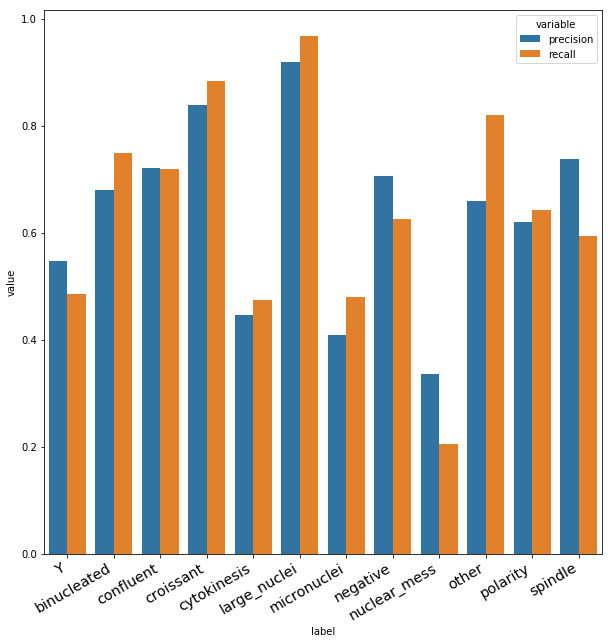

In [3]:
Image(filename='/Users/antonogorodnikov/Documents/Work/DataSci/01_sudoku_image/reports/graphs/prec_recall_aug.png',
      width=500, height=200)

## Update 190904  
To filter out excess of normal cells I created an adversarial convolutional autoencoder (ACAE). 

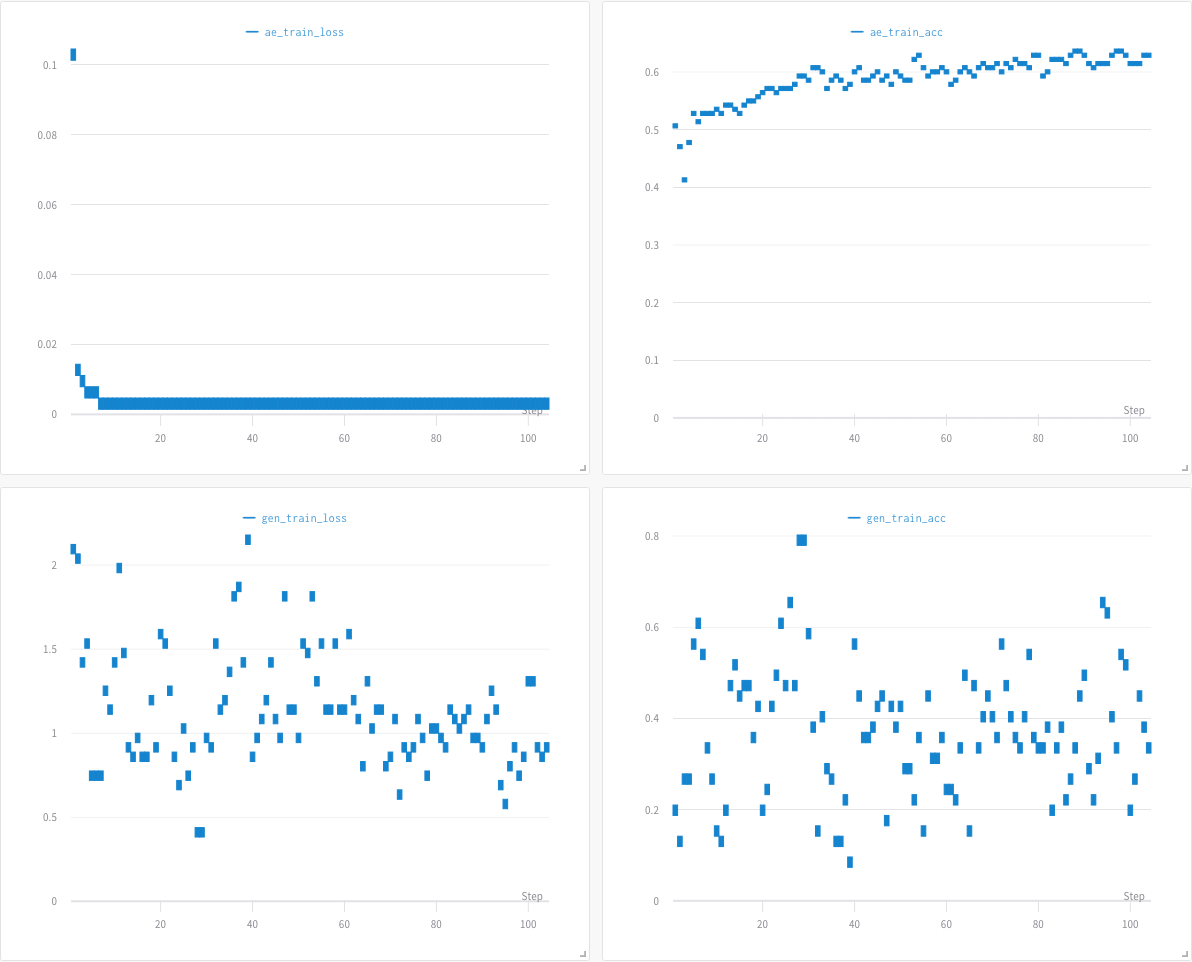

In [5]:
Image(filename='/Users/antonogorodnikov/Documents/Work/DataSci/01_sudoku_image/reports/wandb/190904_ACAE/ACAE_1k_100ep.png',
      width=1000, height=400)

## Class losses  
[['confluent', 0.00523342445699705],  
 ['cytokinesis', 0.006011901500697334],  
 ['negative', 0.004677478751843775],  
 ['nuclear_mess', 0.006141580908649391],  
 ['large_nuclei', 0.005067302334658115],  
 ['other', 0.004034445741920349],  
 ['micronuclei', 0.005565899473682629],  
 ['spindle', 0.004586365225971962],  
 ['Y', 0.005330058731928919],  
 ['binucleated', 0.004883372108452022],  
 ['polarity', 0.005067527480423451],  
 ['croissant', 0.004734548120663325]]  

## Update 190916  
ACAE trained for 1500 epochs - which gave better results overall

In [3]:
Image(filename='/Users/antonogorodnikov/Documents/Work/DataSci/01_sudoku_image/reports/wandb/190916_ACAE/ACAE_1k_rgb_1500ep.png',
      width=1000, height=400)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/antonogorodnikov/Documents/Work/DataSci/01_sudoku_image/reports/wandb/190916_ACAE/ACAE_1k_rgb_1500ep.png'

## Class closses  
[['confluent', [0.003990047197375033, 0.7823838467126364]],  
 ['cytokinesis', [0.00479467329197227, 0.8040526820209637]],  
 ['negative', [0.002872665228779524, 0.7411487153192767]],  
 ['nuclear_mess', [0.004974675755346975, 0.8267828428556049]],  
 ['large_nuclei', [0.0037249213012854722, 0.8074777071215525]],  
 ['other', [0.0028704403019306998, 0.7546617584569113]],  
 ['micronuclei', [0.004338426713170952, 0.8185977354120456]],  
 ['spindle', [0.00319564609858049, 0.7359470431517838]],  
 ['Y', [0.004104753278873183, 0.7166841346876962]],  
 ['binucleated', [0.003716825449373573, 0.8022964660610472]],  
 ['polarity', [0.003804593114182353, 0.7368772821766989]],  
 ['croissant', [0.003620269022948383, 0.7348328779777283]]]

# Conclusions  
1. *Negative* class has the smallest autoencoder and a small adversarial loss.  
2. An anomaly will be determined by the logic `if {dv_loss OR rec_loss} > 60'th percentile` 

# ToDo  
1. Filter out negatives on for plate 4 as a test and re-cluster  
2. Do also grid for reconstruction